## 📚 Maintenance Log

This notebook reads **`data/events/logs.xlsx`** (mixed English & Arabic fields), then:
- 📥 Loads the log and **cleans headers** (handles line breaks/quotes/extra spaces)
- 📊 Summarizes **main statistics** (counts, durations, costs)
- 🔎 Generates **quick insights** (top problems, cost drivers, completion rate)
- 📈 Visualizes **distributions & trends**

> Example fields (may vary by file): `Line, MCCE equipment, MCCDescription, ProblemsItems, Action, jobcompleted, Shift, Month, IssueDate, EndDate, Starttime, Finishtime, NetTime, D.T Time, R.T Time, W O, M C C, PersonFinishJob, SpareStatusandorigin-from, SAPNo, SAPCode, SpareParts, quantity, LE/Uintes, PMCM, Reason`

### ⚙️ Imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Display helper for nice tables in UI (if available)
try:
    from ace_tools import display_dataframe_to_user as display_df
except Exception:
    display_df = None

plt.rcParams['figure.figsize'] = (9, 5)

### 📝 Arabic fonts & shaping for charts

Matplotlib doesn't fully shape Right‑to‑Left (RTL) scripts like Arabic by default.  
We use **arabic_reshaper** + **python-bidi** to render Arabic text correctly and try to pick an installed font that supports Arabic (e.g., *Noto Naskh Arabic*, *Amiri*, *Cairo*, *Tahoma*, *Arial*, *Segoe UI*).

> If needed, install once (uncomment and run):
>
> ```python
> # %pip install arabic-reshaper python-bidi
> ```


In [2]:
import matplotlib
from matplotlib import font_manager as fm

# Pick an Arabic-capable font if available
preferred_fonts = ["Noto Naskh Arabic", "Amiri", "Cairo", "Tahoma", "Arial", "Segoe UI", "Times New Roman"]
chosen_font = None
try:
    faces = []
    for fpath in fm.findSystemFonts():
        try:
            name = fm.FontProperties(fname=fpath).get_name()
            faces.append(name)
        except Exception:
            pass
    for name in preferred_fonts:
        if name in faces:
            chosen_font = name
            break
except Exception:
    pass

if chosen_font is None:
    chosen_font = matplotlib.rcParams.get("font.family", ["DejaVu Sans"])[0]

matplotlib.rcParams["font.family"] = chosen_font
matplotlib.rcParams["axes.unicode_minus"] = False  # ensure minus sign renders

# Arabic shaping helpers
try:
    import arabic_reshaper
    from bidi.algorithm import get_display

    def ar_text(s):
        if s is None:
            return ""
        s = str(s)
        # reshape for proper glyph forms then apply bidi for RTL
        return get_display(arabic_reshaper.reshape(s))
except Exception:
    # Fallback: return the original string if libs are missing
    def ar_text(s):
        return "" if s is None else str(s)

print("Using font for charts:", chosen_font)


Using font for charts: Tahoma


### 📥 Load `logs.xlsx`

In [3]:
path = Path('data/logs/log_data.xlsx')
assert path.exists(), f"Excel file not found: {path} (please place logs.xlsx under data/events/)"

# Read Excel with pandas (openpyxl engine is auto-picked if available)
df_raw = pd.read_excel(path)

print("Loaded shape:", df_raw.shape)
df_raw.head()

Loaded shape: (21, 26)


,line,MCCE\nquipment,MCCDescription,ProblemsItems,Action,jobcompleted,Shift,Month,IssueDate,EndDate,...,M C C,PersonFinishJob,SpareStatusandorigin-from,SAPNo,SAPCode,SpareParts,quantity,LE/Uintes,PMCM,Reason
0,Line 4,0405PP03,طلمبة الزيت الرئيسية,فك طلمبة الزيت وتركيب ميكانيكال سيل,تم التركيب,Yes,2,January,2020-01-15,2020-01-15,...,9350.0,Ahmed Abdullah,Warehouse,6.902682e+09,860010601.0,"Seal Pump 2.5"" -‏ BME119A-A00 (20503157)",1.0,70952.33,CM,Technical
1,Line 4,0405pp03,طلمبة الزيت الرئيسية,كاوتشه كوبلنج,تم التركيب,Yes,2,January,2020-01-11,2020-01-12,...,9347.0,Saleh Ibrahim,Warehouse,6.902590e+09,860076793.0,"Shaft Coupling 2.5""-75mm F120 (20528660)",1.0,14030.43,CM,Technical
2,Line 4,0405pp03,طلمبة الزيت الرئيسية,ميكانيكال سيل ص أ,تم التركيب,Yes,2,January,2020-01-11,2020-01-12,...,9347.0,Saleh Ibrahim,NaN,NaN,NaN,ميكانيكال سيل ض أ,1.0,NaN,CM,Technical
3,Line 4,0405PP03,طلمبة الزيت الرئيسية,فصل طلمبة الزيت الرئيسيه,تم التصحيح والتشغيل,Yes,1,January,2020-01-17,2020-01-17,...,NaN,Khaled Sultan,NaN,NaN,NaN,NaN,NaN,NaN,CM,Technical
4,Line 6,0612PP01,Main Oil Circulation Pump,اويل سيل RC25091 طلمبه الزيت,تم التركيب,Yes,2,January,2020-01-05,2020-01-05,...,9138.0,Abdullah Essam,Warehouse,6.902327e+09,860081160.0,اويل سيل RC25091,2.0,600.00,CM,Technical


### 🧹 Clean headers (mixed English/Arabic)

In [4]:
def clean_header(name: str) -> str:
    # Normalize whitespace, remove quotes and newlines
    s = str(name).replace('\n', ' ').replace('\r', ' ').replace('"', '').strip()
    s = re.sub(r'\s+', ' ', s)  # collapse spaces
    # Keep original language; create a safe ascii-like key for convenience
    key = s.lower()
    key = key.replace('/', '_').replace('-', '_')
    key = re.sub(r'[^\w\s]', '', key)  # drop non-alnum (keeps unicode letters/digits/_)
    key = re.sub(r'\s+', '_', key).strip('_')
    return key

orig_cols = list(df_raw.columns)
clean_map = {c: clean_header(c) for c in df_raw.columns}
df = df_raw.rename(columns=clean_map)

print("Original → Cleaned column names (first 20):")
for o, c in list(clean_map.items())[:20]:
    print(f"- {o} → {c}")

df.head()

Original → Cleaned column names (first 20):
- line → line
- MCCE
quipment → mcce_quipment
- MCCDescription → mccdescription
- ProblemsItems → problemsitems
- Action → action
- jobcompleted → jobcompleted
- Shift → shift
- Month → month
- IssueDate → issuedate
- EndDate → enddate
- Starttime → starttime
- Finishtime → finishtime
- NetTime → nettime
- D.T Time → dt_time
- R.T Time → rt_time
- W O → w_o
- M C C → m_c_c
- PersonFinishJob → personfinishjob
- SpareStatusandorigin-from → sparestatusandorigin_from
- SAPNo → sapno


,line,mcce_quipment,mccdescription,problemsitems,action,jobcompleted,shift,month,issuedate,enddate,...,m_c_c,personfinishjob,sparestatusandorigin_from,sapno,sapcode,spareparts,quantity,le_uintes,pmcm,reason
0,Line 4,0405PP03,طلمبة الزيت الرئيسية,فك طلمبة الزيت وتركيب ميكانيكال سيل,تم التركيب,Yes,2,January,2020-01-15,2020-01-15,...,9350.0,Ahmed Abdullah,Warehouse,6.902682e+09,860010601.0,"Seal Pump 2.5"" -‏ BME119A-A00 (20503157)",1.0,70952.33,CM,Technical
1,Line 4,0405pp03,طلمبة الزيت الرئيسية,كاوتشه كوبلنج,تم التركيب,Yes,2,January,2020-01-11,2020-01-12,...,9347.0,Saleh Ibrahim,Warehouse,6.902590e+09,860076793.0,"Shaft Coupling 2.5""-75mm F120 (20528660)",1.0,14030.43,CM,Technical
2,Line 4,0405pp03,طلمبة الزيت الرئيسية,ميكانيكال سيل ص أ,تم التركيب,Yes,2,January,2020-01-11,2020-01-12,...,9347.0,Saleh Ibrahim,NaN,NaN,NaN,ميكانيكال سيل ض أ,1.0,NaN,CM,Technical
3,Line 4,0405PP03,طلمبة الزيت الرئيسية,فصل طلمبة الزيت الرئيسيه,تم التصحيح والتشغيل,Yes,1,January,2020-01-17,2020-01-17,...,NaN,Khaled Sultan,NaN,NaN,NaN,NaN,NaN,NaN,CM,Technical
4,Line 6,0612PP01,Main Oil Circulation Pump,اويل سيل RC25091 طلمبه الزيت,تم التركيب,Yes,2,January,2020-01-05,2020-01-05,...,9138.0,Abdullah Essam,Warehouse,6.902327e+09,860081160.0,اويل سيل RC25091,2.0,600.00,CM,Technical


### 🧩 Parse dates/times & numeric fields

In [5]:
# Likely date columns
for col in ['issuedate','enddate']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# Net/downtime/runtime minutes (may be numbers stored as strings)
for col in ['nettime','d_t_time','r_t_time','quantity','le_uintes']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Normalize 'jobcompleted' to True/False strings
if 'jobcompleted' in df.columns:
    jc = df['jobcompleted'].astype(str).str.strip().str.lower()
    df['jobcompleted_bool'] = jc.isin(['yes','y','1','true','completed','تم التركيب','تم التصحيح والتشغيل'])

# Try to standardize machine_status style if present (optional)
if 'machine_status' in df.columns:
    ms_num = pd.to_numeric(df['machine_status'], errors='coerce')
    label_map = {0:'idle', 1:'running', 2:'error'}
    df['machine_status_label'] = ms_num.map(label_map).fillna(df['machine_status'].astype(str))

print("Parsed/typed a few common fields.")
df.head()

Parsed/typed a few common fields.


,line,mcce_quipment,mccdescription,problemsitems,action,jobcompleted,shift,month,issuedate,enddate,...,personfinishjob,sparestatusandorigin_from,sapno,sapcode,spareparts,quantity,le_uintes,pmcm,reason,jobcompleted_bool
0,Line 4,0405PP03,طلمبة الزيت الرئيسية,فك طلمبة الزيت وتركيب ميكانيكال سيل,تم التركيب,Yes,2,January,2020-01-15,2020-01-15,...,Ahmed Abdullah,Warehouse,6.902682e+09,860010601.0,"Seal Pump 2.5"" -‏ BME119A-A00 (20503157)",1.0,70952.33,CM,Technical,True
1,Line 4,0405pp03,طلمبة الزيت الرئيسية,كاوتشه كوبلنج,تم التركيب,Yes,2,January,2020-01-11,2020-01-12,...,Saleh Ibrahim,Warehouse,6.902590e+09,860076793.0,"Shaft Coupling 2.5""-75mm F120 (20528660)",1.0,14030.43,CM,Technical,True
2,Line 4,0405pp03,طلمبة الزيت الرئيسية,ميكانيكال سيل ص أ,تم التركيب,Yes,2,January,2020-01-11,2020-01-12,...,Saleh Ibrahim,NaN,NaN,NaN,ميكانيكال سيل ض أ,1.0,NaN,CM,Technical,True
3,Line 4,0405PP03,طلمبة الزيت الرئيسية,فصل طلمبة الزيت الرئيسيه,تم التصحيح والتشغيل,Yes,1,January,2020-01-17,2020-01-17,...,Khaled Sultan,NaN,NaN,NaN,NaN,NaN,NaN,CM,Technical,True
4,Line 6,0612PP01,Main Oil Circulation Pump,اويل سيل RC25091 طلمبه الزيت,تم التركيب,Yes,2,January,2020-01-05,2020-01-05,...,Abdullah Essam,Warehouse,6.902327e+09,860081160.0,اويل سيل RC25091,2.0,600.00,CM,Technical,True


> ℹ️ **Note on date parsing**: `infer_datetime_format` is deprecated in pandas and no longer needed.
> We removed it and kept `dayfirst=True`. If your dates vary in format, pandas now parses strictly by default.


### 📊 Main statistics

In [6]:
stats = {}

stats['rows'] = len(df)
for col in ['line','mccdescription','problemsitems','action','reason','spareparts','pmcm','shift','month']:
    if col in df.columns:
        stats[f'unique_{col}'] = df[col].astype(str).nunique()

if 'issuedate' in df.columns:
    stats['date_min'] = str(df['issuedate'].min())
    stats['date_max'] = str(df['issuedate'].max())

# Durations (minutes)
for col in ['nettime','d_t_time','r_t_time']:
    if col in df.columns:
        stats[f'sum_{col}'] = float(df[col].fillna(0).sum())
        stats[f'avg_{col}'] = float(df[col].fillna(0).mean())

# Completion rate
if 'jobcompleted_bool' in df.columns:
    stats['jobcompleted_rate'] = float(df['jobcompleted_bool'].mean())

# Cost estimation (quantity * LE/Uintes)
if 'quantity' in df.columns and 'le_uintes' in df.columns:
    df['__total_cost'] = df['quantity'].fillna(0) * df['le_uintes'].fillna(0)
    stats['total_cost'] = float(df['__total_cost'].sum())
    stats['avg_cost_per_job'] = float(df['__total_cost'].mean())

print("Key statistics:")
for k, v in stats.items():
    print(f"- {k}: {v}")

# Show as a table
stats_df = pd.DataFrame(list(stats.items()), columns=['metric','value'])
display(stats_df)
if display_df:
    try:
        display_df("Main statistics", stats_df)
    except Exception:
        pass

Key statistics:
- rows: 21
- unique_line: 4
- unique_mccdescription: 4
- unique_problemsitems: 20
- unique_action: 9
- unique_reason: 1
- unique_spareparts: 10
- unique_pmcm: 1
- unique_shift: 3
- unique_month: 1
- date_min: 2020-01-02 00:00:00
- date_max: 2020-01-27 00:00:00
- sum_nettime: 1370.0
- avg_nettime: 65.23809523809524
- jobcompleted_rate: 1.0
- total_cost: 119617.80000000002
- avg_cost_per_job: 5696.085714285715


,metric,value
0,rows,21
1,unique_line,4
2,unique_mccdescription,4
3,unique_problemsitems,20
4,unique_action,9
5,unique_reason,1
6,unique_spareparts,10
7,unique_pmcm,1
8,unique_shift,3
9,unique_month,1


### 🧱 Top categories


Top problemsitems:
 problemsitems
ضبط دائرة السيفتي للكيسه وضبط وتثبيت السويتشات                2
فك طلمبة الزيت وتركيب ميكانيكال سيل                           1
ميكانيكال سيل ص أ                                             1
كاوتشه كوبلنج                                                 1
فصل طلمبة الزيت الرئيسيه                                      1
اويل سيل RC25091    طلمبه الزيت                               1
اللارم في زون 5                                               1
سلونيد فالف                                                   1
انخفاض لسرعة الموتور مما ادي الي تقلب الجوده وتجميع المنتج    1
انخفاض خرج الموتور                                            1
Name: count, dtype: int64

Top spareparts:
 spareparts
nan                                         9
FLEXIBLE PATTLC ( GLAB0401 )‏               4
Shaft Coupling 2.5"-75mm F120 (20528660)    1
Seal Pump 2.5" -‏ BME119A-A00 (20503157)    1
اويل سيل RC25091                            1
ميكانيكال سيل ض أ                       

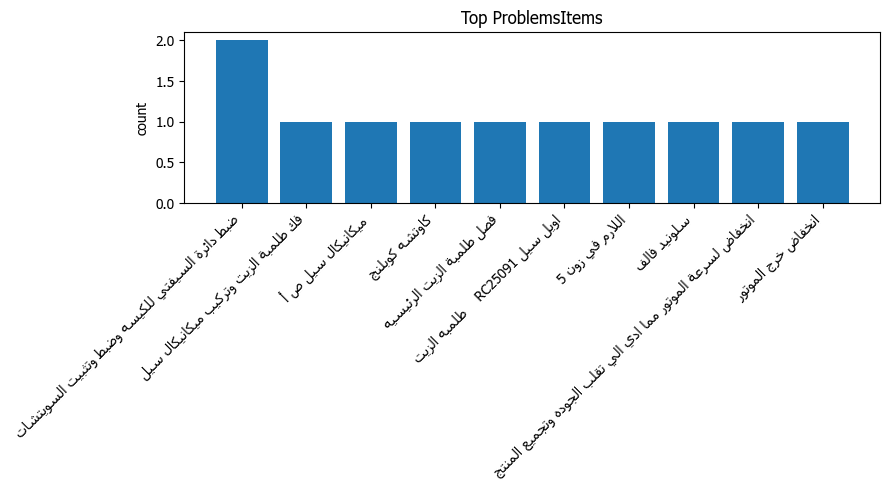

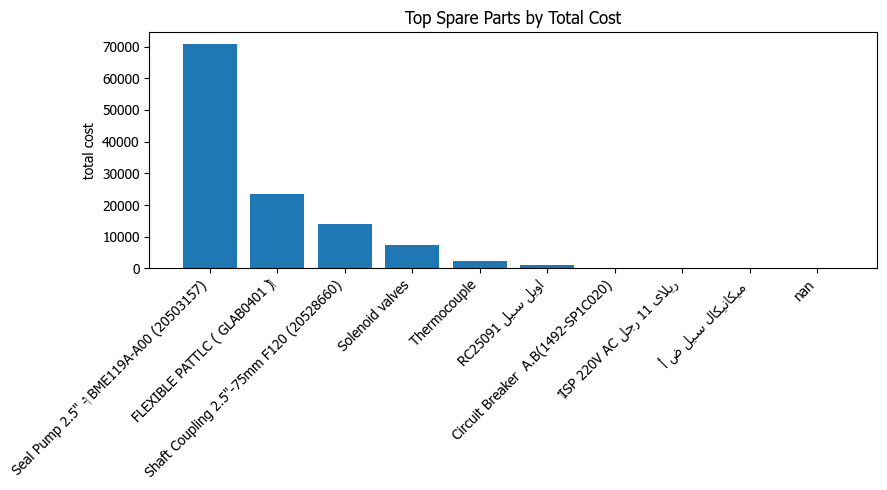

In [7]:
def top_counts(series, n=10):
    return series.astype(str).replace({'':np.nan}).dropna().value_counts().head(n)

tops = {}
for col in ['problemsitems','spareparts','reason','mccdescription','action']:
    if col in df.columns:
        tops[col] = top_counts(df[col], n=10)
        print(f"\nTop {col}:\n", tops[col])

# Visualize a couple (matplotlib only, one plot per figure)
if 'problemsitems' in df.columns:
    vc = top_counts(df['problemsitems'], 10)
    plt.figure()
    labels = [ar_text(x) for x in vc.index.astype(str)]
    plt.bar(range(len(vc.values)), vc.values)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.title('Top ProblemsItems')
    
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

if '__total_cost' in df.columns and 'spareparts' in df.columns:
    cost_by_part = df.groupby('spareparts', dropna=False)['__total_cost'].sum().sort_values(ascending=False).head(10)
    plt.figure()
    labels2 = [ar_text(x) for x in cost_by_part.index.astype(str)]
    plt.bar(range(len(cost_by_part.values)), cost_by_part.values)
    plt.xticks(range(len(labels2)), labels2, rotation=45, ha='right')
    plt.title('Top Spare Parts by Total Cost')
    
    plt.ylabel('total cost')
    plt.tight_layout()
    plt.show()

### 💡 Insights

In [8]:
insights = []

# 1) Most frequent problem
if 'problemsitems' in df.columns:
    vc = df['problemsitems'].astype(str).value_counts()
    if len(vc) > 0:
        top_problem, top_count = vc.index[0], int(vc.iloc[0])
        insights.append(f"Top problem item: '{top_problem}' ({top_count} occurrences)." )
        insights.append(f"أكثر مشكلة تكرارًا: '{top_problem}' بعدد {top_count}.")

# 2) Highest cost spare part
if '__total_cost' in df.columns and 'spareparts' in df.columns:
    cost_by_part = df.groupby('spareparts', dropna=False)['__total_cost'].sum().sort_values(ascending=False)
    if len(cost_by_part) > 0:
        top_part, top_cost = cost_by_part.index[0], float(cost_by_part.iloc[0])
        insights.append(f"Highest total cost spare part: '{top_part}' with {top_cost:,.2f}.")
        insights.append(f"أعلى تكلفة إجمالية لقطع الغيار: '{top_part}' بقيمة {top_cost:,.2f}.")

# 3) Completion rate
if 'jobcompleted_bool' in df.columns:
    rate = float(df['jobcompleted_bool'].mean()) if len(df) else 0.0
    insights.append(f"Job completion rate: {rate*100:.1f}%.")
    insights.append(f"نسبة إكمال الأعمال: {rate*100:.1f}٪.")

# 4) Average NetTime by Shift
if 'nettime' in df.columns and 'shift' in df.columns:
    avg_by_shift = df.groupby('shift')['nettime'].mean().sort_values(ascending=False)
    if len(avg_by_shift) > 0:
        top_shift, top_val = avg_by_shift.index[0], float(avg_by_shift.iloc[0])
        insights.append(f"Shift with highest average NetTime: {top_shift} ({top_val:.1f} minutes)." )
        insights.append(f"الوردية ذات أعلى متوسط زمن صافي: {top_shift} ({top_val:.1f} دقيقة)." )

print("\n".join(insights) if insights else "No automatic insights derived." )


Top problem item: 'ضبط دائرة السيفتي للكيسه وضبط وتثبيت السويتشات ' (2 occurrences).
أكثر مشكلة تكرارًا: 'ضبط دائرة السيفتي للكيسه وضبط وتثبيت السويتشات ' بعدد 2.
Highest total cost spare part: 'Seal Pump 2.5" -‏ BME119A-A00 (20503157)' with 70,952.33.
أعلى تكلفة إجمالية لقطع الغيار: 'Seal Pump 2.5" -‏ BME119A-A00 (20503157)' بقيمة 70,952.33.
Job completion rate: 100.0%.
نسبة إكمال الأعمال: 100.0٪.
Shift with highest average NetTime: 3 (95.0 minutes).
الوردية ذات أعلى متوسط زمن صافي: 3 (95.0 دقيقة).
